In [1]:
# Importing necessary libraries

import os
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from functools import partial

2023-12-16 13:01:55.383717: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Processing Images
### Converting JPEG images into rows of pixels

In [2]:
# Retrieving ground truth data (skin lesion diagnoses)
ground_truth_train_path = './archive/ISIC2018_Task3_Training_GroundTruth.csv'
ground_truth_train_df = pd.read_csv(ground_truth_train_path)

ground_truth_test_path = './archive/ISIC2018_Task3_Test_GroundTruth.csv'
ground_truth_test_df = pd.read_csv(ground_truth_test_path)

ground_truth_df = pd.concat([ground_truth_train_df, ground_truth_test_df], axis=0)
CLASSES = ground_truth_df.columns.to_list()[1:]

In [3]:
# Converting images to pixel numpy arrays
PIXELS = 28
IMG_DIRS_TRAIN = ['./archive/HAM10000_images_part_1/', './archive/HAM10000_images_part_2/']
IMG_DIRS_TEST = ['./archive/ISIC2018_Task3_Test_Input/']

header = np.array([f'pixel{i:04}' for i in range(PIXELS * PIXELS * 3)] + CLASSES)
data_train, data_test = [header], [header]
for data, IMG_DIRS in zip([data_train, data_test], [IMG_DIRS_TRAIN, IMG_DIRS_TEST]):
    for IMG_DIR in IMG_DIRS:
        print(f'Working through: {IMG_DIR}')
        for img in os.listdir(IMG_DIR):
            # Getting pixel values from original jpg image
            bgr_array = cv2.imread(os.path.join(IMG_DIR, img), cv2.IMREAD_COLOR)
            bgr_pil = Image.fromarray(bgr_array)
            bgr_resized = np.array(bgr_pil.resize((PIXELS, PIXELS)))
            bgr_array = bgr_resized.flatten()

            # Restructuring from BGR to RGB
            rgb_list = []
            for i in range(PIXELS ** 2):
                b, g, r = bgr_array[(3 * i):(i * 3) + 3]
                rgb_list += [r, g, b]
            rgb_array = np.array(rgb_list)

            # Getting classification
            img_id = img.split('.')[0]
            classification_array = ground_truth_df.loc[ground_truth_df['image'] == img_id, CLASSES].to_numpy()
            instance_array = np.append(rgb_array, classification_array)

            # Adding image data to data list
            data.append(instance_array)

data_array_train = np.array(data_train)
data_array_test = np.array(data_test)
print(f'Shape of training data: {data_array_train.shape}')
print(f'Shape of testing data: {data_array_test.shape}')


Working through: ./archive/HAM10000_images_part_1/
Working through: ./archive/HAM10000_images_part_2/
Working through: ./archive/ISIC2018_Task3_Test_Input/
Shape of training data: (10016, 2359)
Shape of testing data: (1513, 2359)


In [4]:
# Preparing plotting functionality

def plot_image(data):
    corrected = data.astype(float).astype(int)
    image = corrected.reshape(PIXELS, PIXELS, 3)
    plt.imshow(image)

    plt.axis('off')

Example of pixelated images:


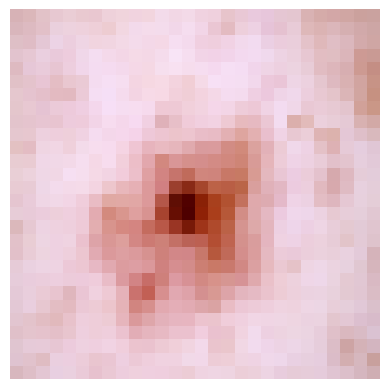

In [5]:
# Plotting an example image
print('Example of pixelated images:')
plot_image(data_array_train[1, :-7])

# Data Augmentation
### Adding variety to data by rotating and flipping images

In [6]:
# Organizing data
hmnist_train = data_array_train[1:]
print(f'Shape of HMNIST data: {hmnist_train.shape}')

Shape of HMNIST data: (10015, 2359)


In [7]:
# Extracting images and OHE labels; and also converting to categorical labels
X_train = hmnist_train[:, :-7]
X_train = X_train.reshape(len(X_train), PIXELS, PIXELS, 3)
print(f'Shape of X train (instance matrix): {X_train.shape}')

labels_train_ohe = hmnist_train[:, -7:]
y_train = np.where(labels_train_ohe == '1.0')[1]
print(f'Shape of y train (labels): {y_train.shape}')

Shape of X train (instance matrix): (10015, 28, 28, 3)
Shape of y train (labels): (10015,)


In [8]:
# Rotating images
rotated_instances = { 1: [], 2: [], 3: [] }
for rotation in rotated_instances:
    for x, y in zip(X_train, y_train):
        rotated_image = np.rot90(x, rotation)
        flattened_image = rotated_image.flatten()
        labeled_instance = np.append(flattened_image, y)
        rotated_instances[rotation].append(labeled_instance)

total_rotations = 0
for rotation in rotated_instances:
    total_rotations += len(rotated_instances[rotation])
                           
print(f'Rotations finished. Generated {total_rotations} rotated images.')

# Adding original (non-rotated) images
rotated_instances[0] = []
for x, y in zip(X_train, y_train):
    flattened_image = x.flatten()
    labeled_instance = np.append(flattened_image, y)
    rotated_instances[0].append(labeled_instance)
all_rotated_instances = rotated_instances[0] + rotated_instances[1] + rotated_instances[2] + rotated_instances[3]

Rotations finished. Generated 30045 rotated images.


Flipping finished. Generated 40060 rotated images.
Example of flipped images:


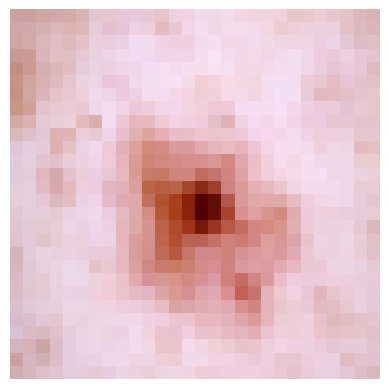

In [9]:
# Flipping images
flipped_instances = []
for rotated_instance in all_rotated_instances:
    x, y = rotated_instance[:-1], rotated_instance[-1]
    image = x.reshape(PIXELS, PIXELS, 3)
    flipped_image = np.fliplr(image)
    flattened_image = flipped_image.flatten()
    labeled_instance = np.append(flattened_image, y)
    flipped_instances.append(labeled_instance)

print(f'Flipping finished. Generated {len(flipped_instances)} rotated images.')
print('Example of flipped images:')
plot_image(flipped_instances[0][:-1])

In [10]:
# Combining all data
all_instances = all_rotated_instances + flipped_instances
all_instances = np.array(all_instances)
print(f'Shape of final instances matrix: {all_instances.shape}')

Shape of final instances matrix: (80120, 2353)


# Building and Training a CNN Model

In [11]:
# Reshaping training data
X_train_aug, y_train_aug = all_instances[:, :-1], all_instances[:, -1]
X_train_aug = X_train_aug.reshape(len(X_train_aug), PIXELS, PIXELS, 3)
print(f'Training features matrix: {X_train_aug.shape}')
print(f'Training labels vector: {y_train_aug.shape}')

Training features matrix: (80120, 28, 28, 3)
Training labels vector: (80120,)


In [12]:
# Scaling and typing data
X_train_aug = X_train_aug.astype(float) / 255.0
y_train_aug = y_train_aug.astype(int)

In [13]:
# Model Implementation
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding='same',
                        activation='relu', kernel_initializer='he_normal')
model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[PIXELS,PIXELS,3]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu',
                          kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation='relu',
                          kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=7, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        9472      
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 128)         0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 256)         2

In [14]:
# Compiling model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy']
)

In [15]:
# Training model
history = model.fit(X_train_aug, y_train_aug, epochs=5)

Epoch 1/5
2504/2504 [==============================] - 228s 91ms/step - loss: 0.9841 - accuracy: 0.6691
Epoch 2/5
2504/2504 [==============================] - 224s 89ms/step - loss: 0.8702 - accuracy: 0.6837
Epoch 3/5
2504/2504 [==============================] - 222s 89ms/step - loss: 0.8168 - accuracy: 0.7009
Epoch 4/5
2504/2504 [==============================] - 223s 89ms/step - loss: 0.7774 - accuracy: 0.7180
Epoch 5/5
2504/2504 [==============================] - 220s 88ms/step - loss: 0.7453 - accuracy: 0.7290


# Testing Model

In [16]:
# Preparing test data
hmnist_test = data_array_test[1:]

X_test = hmnist_test[:, :-7].astype(float)
X_test = X_test.reshape(len(X_test), PIXELS, PIXELS, 3)
print(f'Shape of X test (instance matrix): {X_test.shape}')

labels_test_ohe = hmnist_test[:, -7:]
y_test = np.where(labels_test_ohe == '1.0')[1]
print(f'Shape of y test (labels): {y_test.shape}')

Shape of X test (instance matrix): (1512, 28, 28, 3)
Shape of y test (labels): (1512,)


In [17]:
# Evaluating model
model.evaluate(X_test, y_test)

48/48 [==============================] - 1s 22ms/step - loss: 177.2093 - accuracy: 0.5866


[177.2093048095703, 0.5866402387619019]